In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import BertModel
import tldextract
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

In [2]:
# Step 1: Load and Prepare Data
fake_news = pd.read_csv('data/fake.csv')  # Replace with the correct path
real_news = pd.read_csv('data/real.csv')  # Replace with the correct path

fake_news = fake_news.drop(columns=['id'], errors='ignore')
real_news = real_news.drop(columns=['id'], errors='ignore')
fake_news['labels'] = 1
real_news['labels'] = 0

data = pd.concat([fake_news[['title', 'labels', 'news_url']], real_news[['title', 'labels', 'news_url']]], ignore_index=True)
data.dropna(subset=['title'], inplace=True)

# Step 2: Refined Data Augmentation
def augment_title(title):
    synonyms = {'fake': 'false', 'news': 'story'}
    words = title.split()
    return ' '.join([synonyms.get(w.lower(), w) for w in words])

data['title'] = data['title'].apply(augment_title)

In [3]:
# Step 3: Extract URL features
def extract_url_features(url):
    if isinstance(url, float):
        url = str(url)
    ext = tldextract.extract(url)
    return {
        'domain': ext.domain,
        'subdomain': ext.subdomain,
        'url_length': len(url),
        'has_query': 1 if '?' in url else 0,
        'has_hyphens': 1 if '-' in url else 0,
        'has_numbers': 1 if any(c.isdigit() for c in url) else 0,
    }

url_features = data['news_url'].apply(extract_url_features)
url_features_df = pd.DataFrame(url_features.tolist())

# Encode and normalize URL features
url_features_encoded = pd.get_dummies(url_features_df, columns=['domain', 'subdomain'])
scaler = StandardScaler()
url_features_encoded = pd.DataFrame(scaler.fit_transform(url_features_encoded), columns=url_features_encoded.columns)

In [4]:
# Step 4: Vectorize Titles
vectorizer = CountVectorizer(max_features=5000)  # Limit features to avoid memory issues
title_features_vectorized = vectorizer.fit_transform(data['title']).toarray()

# Step 5: Align Data
min_length = min(len(title_features_vectorized), len(url_features_encoded))
title_features_vectorized = title_features_vectorized[:min_length]
url_features_encoded = url_features_encoded.iloc[:min_length]
data = data.iloc[:min_length]

# Step 6: Combine Features for SMOTE
combined_features = np.hstack([title_features_vectorized, url_features_encoded])

# Apply SMOTE
smote = SMOTE(random_state=42)
combined_features_resampled, labels_resampled = smote.fit_resample(combined_features, data['labels'])

# Step 7: Split Combined Features Back
title_features_resampled = combined_features_resampled[:, :title_features_vectorized.shape[1]]
url_features_resampled = combined_features_resampled[:, title_features_vectorized.shape[1]:]

# Convert resampled title features back to text
title_features_resampled = [
    " ".join(vectorizer.inverse_transform(title_row.reshape(1, -1))[0]) for title_row in title_features_resampled
]



C:\Users\jun_k\anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\jun_k\anaconda3\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [5]:
from transformers import BertTokenizer
import torch

# Tokenizer initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Step 8: Split Data into Train/Test Sets
train_texts, test_texts, train_labels, test_labels, train_urls, test_urls = train_test_split(
    title_features_resampled, labels_resampled, url_features_resampled, test_size=0.2, random_state=42
)
print("Data preparation complete.")
# Tokenize the train and test texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Convert to torch tensors
train_encodings = {key: torch.tensor(val) for key, val in train_encodings.items()}
test_encodings = {key: torch.tensor(val) for key, val in test_encodings.items()}

class CombinedDataset(Dataset):
    def __init__(self, encodings, labels, url_features):
        self.encodings = encodings
        self.labels = labels
        self.url_features = torch.tensor(url_features, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        item['url_features'] = self.url_features[idx]
        return item

# Create datasets
train_dataset = CombinedDataset(train_encodings, train_labels, train_urls)
test_dataset = CombinedDataset(test_encodings, test_labels, test_urls)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_dataloader = DataLoader(test_dataset, batch_size=16)


Data preparation complete.


In [6]:
# Model with enhanced URL features
class BertWithEnhancedURLClassifier(nn.Module):
    def __init__(self, bert_model_name, url_feature_dim):
        super(BertWithEnhancedURLClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.url_transform = nn.Sequential(
            nn.Linear(url_feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.classifier = nn.Linear(self.bert.config.hidden_size + 64, 2)

    def forward(self, input_ids, attention_mask, url_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        url_transformed = self.url_transform(url_features)
        combined_input = torch.cat((bert_output, url_transformed), dim=1)
        logits = self.classifier(combined_input)
        return logits

url_feature_dim = train_urls.shape[1]
model = BertWithEnhancedURLClassifier('bert-base-uncased', url_feature_dim)

In [7]:
# Model training function
def train_model(model, train_dataloader, eval_dataloader, num_epochs, device):
    optimizer = AdamW(model.parameters(), lr=1e-5)
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    model.to(device)
    progress_bar = tqdm(range(num_training_steps))

    for epoch in range(num_epochs):
        model.train()
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                url_features=batch["url_features"]
            )
            logits = outputs
            loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.5], device=device))
            loss = loss_fct(logits, batch["labels"])

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        model.eval()
        eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    url_features=batch["url_features"]
                )
                logits = outputs
                loss = loss_fct(logits, batch["labels"])
                eval_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Evaluation Loss: {eval_loss / len(eval_dataloader)}")
    return model

In [8]:
# Train Model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_epochs = 5
model = train_model(model, train_dataloader, eval_dataloader, num_epochs, device)

# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
}, "fake_news_model_v2.pth")
print("Model saved as fake_news_model_v2.pth")

 20%|██████████████▊                                                           | 1745/8725 [2:14:26<7:15:47,  3.75s/it]

Epoch 1/5, Evaluation Loss: 0.30590816456781916


 40%|█████████████████████████████▌                                            | 3490/8725 [4:37:16<4:49:09,  3.31s/it]

Epoch 2/5, Evaluation Loss: 0.27553275727519866


 60%|████████████████████████████████████████████▍                             | 5235/8725 [7:01:33<4:01:12,  4.15s/it]

Epoch 3/5, Evaluation Loss: 0.2806840967642702


 80%|███████████████████████████████████████████████████████████▏              | 6980/8725 [9:30:21<1:51:09,  3.82s/it]

Epoch 4/5, Evaluation Loss: 0.3152889812432306


100%|███████████████████████████████████████████████████████████████████████████| 8725/8725 [12:08:46<00:00,  5.01s/it]

Epoch 5/5, Evaluation Loss: 0.3381337827679997


Model saved as fake_news_model_v2.pth


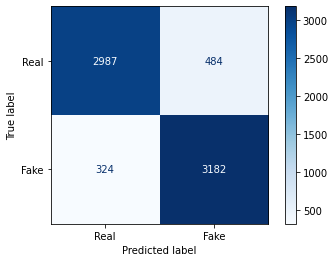

Accuracy: 0.8841909129998566
              precision    recall  f1-score   support

        Real       0.90      0.86      0.88      3471
        Fake       0.87      0.91      0.89      3506

    accuracy                           0.88      6977
   macro avg       0.89      0.88      0.88      6977
weighted avg       0.88      0.88      0.88      6977



In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import numpy as np

# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            url_features=batch["url_features"]
        )
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch["labels"].cpu().numpy())

# Save predictions and true labels (optional)
np.save("predictions_v2.npy", predictions)
np.save("true_labels_v2.npy", true_labels)

# Evaluation Metrics
conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Real', 'Fake'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print("Accuracy:", accuracy_score(true_labels, predictions))
print(classification_report(true_labels, predictions, target_names=['Real', 'Fake']))
